In [1]:
import os
import json
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as Optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from PIL import Image, ImageEnhance

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import conf

data_dir = "data/robo_camv2_timed"

batch_size = conf.training_batch_size
epochs = conf.training_epochs
img_height = conf.image_height
img_width = conf.image_width
img_channels = conf.image_depth

crop_top = conf.crop_top

class_nb = (len(conf.speed_idx), len(conf.angle_idx))

val_split = conf.val_split

seq_len = conf.seq_len

model_name = "models/model_multi_test.h5"

In [3]:
raw_Y = []
for f in os.listdir(data_dir):
    if f.endswith(".json") and "meta" not in f:
        with open(os.path.join(data_dir, f)) as fd:
            data_id = f.split("_")[1].split(".")[0]
            data = json.load(fd)
            raw_Y.append({"id": int(data_id), "throttle": data["user/throttle"], "angle": data["user/angle"]})
            
raw_Y = sorted(raw_Y, key=lambda item: item["id"])
len(raw_Y)

26433

In [4]:
def plot_values(Y):
    fig, ax = plt.subplots(2,1)
    ax[0].plot([Y[i]["throttle"] for i in range(len(Y))])
    ax[1].plot([Y[i]["angle"] for i in range(len(Y))])

<IPython.core.display.Javascript object>


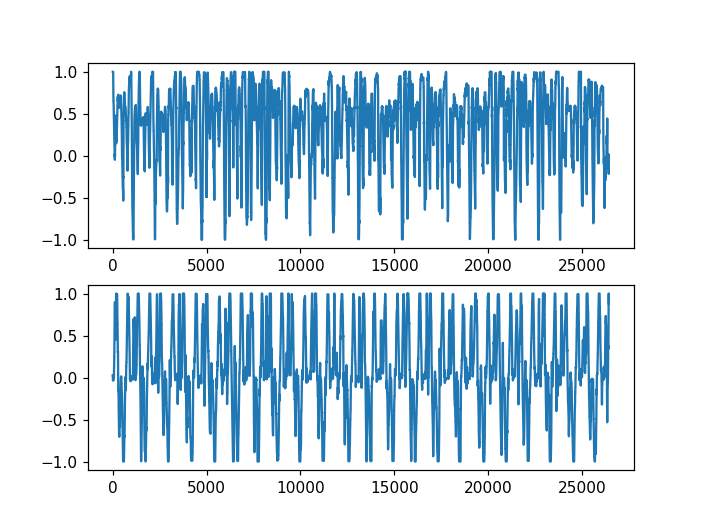

In [5]:
plot_values(raw_Y)

In [6]:
Y = []
for i in [x["id"] for x in raw_Y]:
    Y.append({"id": i})
    if (raw_Y[i]["throttle"] < conf.speed_lims[0]):
        Y[i]["throttle"] = 0
    elif (raw_Y[i]["throttle"] < conf.speed_lims[1]):
        Y[i]["throttle"] = 1
    else:
        Y[i]["throttle"] = 2
    
    if (raw_Y[i]["angle"] < conf.angle_lims[0]):
        Y[i]["angle"] = 0
    elif (raw_Y[i]["angle"] < conf.angle_lims[1]):
        Y[i]["angle"] = 1
    elif (raw_Y[i]["angle"] < conf.angle_lims[2]):
        Y[i]["angle"] = 2
    elif (raw_Y[i]["angle"] < conf.angle_lims[3]):
        Y[i]["angle"] = 3
    else:#if (raw_Y[i]["angle"] < conf.angle_lims[4]):
        Y[i]["angle"] = 4
    """elif (raw_Y[i]["angle"] < conf.angle_lims[5]):
        Y[i]["angle"] = 5
    else:
        Y[i]["angle"] = 6"""

<IPython.core.display.Javascript object>


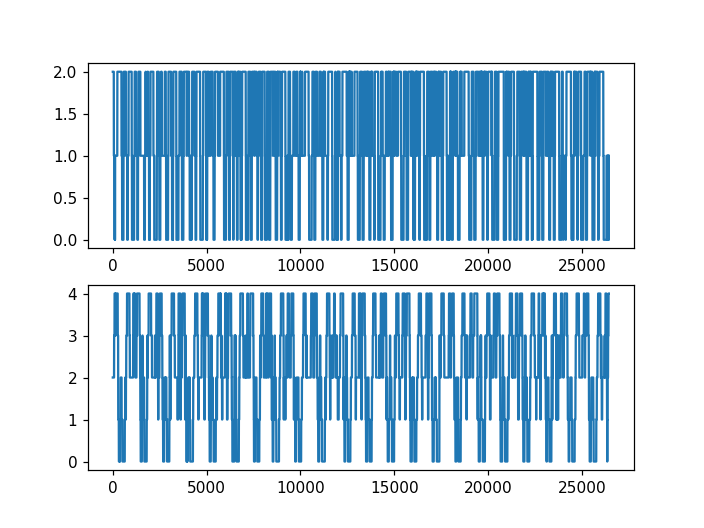

In [7]:
plot_values(Y)

<IPython.core.display.Javascript object>


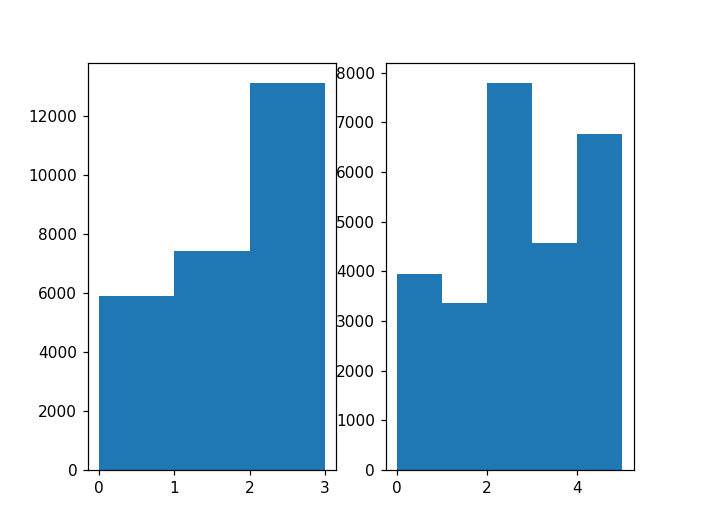

(array([3937., 3355., 7795., 4577., 6769.]),
 array([0., 1., 2., 3., 4., 5.]),
 <a list of 5 Patch objects>)

In [8]:
sum_sp = []
sum_dir = []

for v in Y:
    sum_sp.append(v["throttle"])
    sum_dir.append(v["angle"])

fig, ax = plt.subplots(1, 2)
ax[0].hist(sum_sp, range=(0, class_nb[0]), bins=class_nb[0])
ax[1].hist(sum_dir, range=(0, class_nb[1]), bins=class_nb[1])

In [9]:
class DataGenerator(Sequence):
    def __init__(self, data, data_path, class_nb, batch_size=32, val=False, val_split=0.2, shuffle=False, mirror=False, noise=None, contrast=False, light=False):
        super().__init__()

        if val:
            self.data = [data[i] for i in range(int((1 - val_split) * len(data)), len(data))]
        else:
            self.data = [data[i] for i in range(0, int((1 - val_split) * len(data)))]
            
        self.val = val
        self.class_nb = class_nb
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.mirror = mirror
        self.noise = noise
        self.light = light
        self.contrast = contrast
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor((len(self.data) - seq_len) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data) - seq_len)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def gaussian_noise(self, img, prob):
        noise = np.random.normal(1, prob ** 0.5, img.shape)
        img = np.multiply(img, noise)
        return img
    
    def add_rects(self, img):
        w = int(np.random.uniform(0.2, 0.4) * img_width)
        h = int(np.random.uniform(0.2, 0.4) * img_height)
        x = np.random.randint(img_width-w)
        y = np.random.randint(img_height-h)
        box = np.array([np.random.randint(0, 100, (h,w,1))])
        img[y:y+h, x:x+w] = box
        return img
        
    def add_noise(self, img):
        p = np.random.rand(1)
        if p < 0.3:
            return self.gaussian_noise(img, 0.02)
        elif p < 0.8:
            return self.add_rects(img)
        return img
    
    def flip_img(self, X, y_dir):
        if np.random.randint(2):
            X = tf.image.flip_left_right(X)
            y_dir = np.flip(y_dir)
        return X, y_dir
    
    def random_light(self, img):
        rnd = np.random.uniform(0.2, 1.8)
        img *= rnd
        return img
    
    def random_contrast(self, img):
        contrast = ImageEnhance.Contrast(img)
        img = contrast.enhance(np.random.uniform(0.2, 1.8))
        return img
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, seq_len, img_height - crop_top, img_width, img_channels), dtype=np.float32)
        y_speed = np.empty((self.batch_size, class_nb[0]), dtype=np.int8)
        y_dir = np.empty((self.batch_size, class_nb[1]), dtype=np.int8)
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        for i, idx in enumerate(indexes):
            for j in range(seq_len):
                img = Image.open(os.path.join(self.data_path, str(self.data[idx + j]["id"]) + "_cam-image_array_.jpg")).convert('L')#.crop((0, crop_top, img_width, img_height))#.convert('L')
                
                if self.val == False and self.contrast:
                    img = self.random_contrast(img)
                
                img = np.expand_dims(np.array(img), 2)

                if self.val == False and self.noise:
                    img = self.add_noise(img)

                    
                X[i,j,] = np.array(img) / 255.0
                
                if self.val == False and self.light:
                    X[i,j,] = self.random_light(X[i,j,])

            y_speed[i,] = to_categorical(self.data[idx + j]["throttle"], num_classes=class_nb[0])
            y_dir[i,] = to_categorical(self.data[idx + j]["angle"], num_classes=class_nb[1])
            
            if self.val == False and self.mirror: 
                X[i,], y_dir[i,] = self.flip_img(X[i,], y_dir[i,])

            X[i,] = np.array(X[i,])
            
        return X, [y_speed, y_dir]


In [10]:
train_batches = DataGenerator(Y, data_dir, class_nb, batch_size=batch_size, val=False , val_split=val_split, shuffle=True, mirror=True, noise=True, contrast=True, light=True)
val_batches = DataGenerator(Y, data_dir, class_nb, batch_size=batch_size, val=True, val_split=val_split, shuffle=False)

288 123


<IPython.core.display.Javascript object>


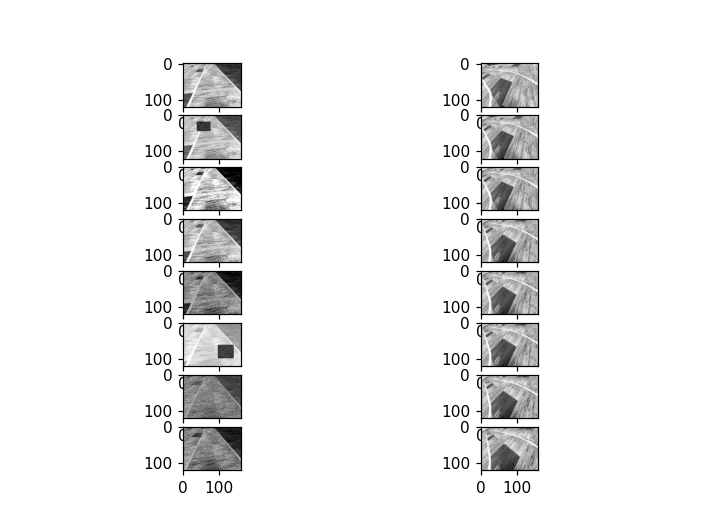

(8, 120, 160, 1) (8, 120, 160, 1)
[0 0 1] [0 0 1 0 0] [0 1 0] [1 0 0 0 0]


In [11]:
batch = 0
idx = 0

print(len(train_batches), len(val_batches))

train_test = train_batches[batch]
val_test = val_batches[batch]

fig, ax = plt.subplots(seq_len, 2)

for j in range(seq_len):
    ax[j][0].imshow(np.squeeze(train_test[0][idx][j]), cmap="gray")
    ax[j][1].imshow(np.squeeze(val_test[0][idx][j]), cmap="gray")
    fig.show()

    
print(train_test[0][idx].shape, val_test[0][idx].shape)
print(train_test[1][0][idx], train_test[1][1][idx], val_test[1][0][idx], val_test[1][1][idx])

In [13]:
K.clear_session()
############################################################# 

img_in = Input(shape=(seq_len, img_height - crop_top, img_width, img_channels), name='img_in')
x = img_in

x = Convolution3D(8, (1,5,5), strides=(1,2,2), activation="relu")(x)       
x = Dropout(.4)(x)
x = Convolution3D(16, (1,5,5), strides=(1,2,2), activation="relu")(x)
x = Dropout(.3)(x)
x = Convolution3D(32, (1,5,5), strides=(1,2,2), activation="relu")(x)       

x = Flatten(name='flattened')(x)

x = Dense(1000, activation="relu")(x)
x = Dropout(.3)(x)
x = Dense(100, activation="relu")(x) 

# Multitask Output
out_speed = Dense(class_nb[0], activation='softmax')(x)
out_dir = Dense(class_nb[1], activation='softmax')(x)

#opti = Optimizers.Adadelta(learning_rate=1.0)

# Compile Model
model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 8, 120, 160, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 8, 58, 78, 8) 208         img_in[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 8, 58, 78, 8) 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 8, 27, 37, 16 3216        dropout[0][0]                    
______________________________________________________________________________________________

In [72]:
K.clear_session()
############################################################# 

img_in = Input(shape=(seq_len, img_height - crop_top, img_width, img_channels), name='img_in')
x = img_in

x = ConvLSTM2D(8, (5,5), strides=(2,2), activation="relu", return_sequences=True)(x)       
#x = BatchNormalization()(x)
#x = Activation("relu")(x)
x = Dropout(.4)(x)
x = ConvLSTM2D(16, (5,5), strides=(2,2), activation="relu", return_sequences=True)(x)       
#x = BatchNormalization()(x)
#x = Activation("relu")(x)
x = ConvLSTM2D(32, (5,5), strides=(2,2), activation="relu", return_sequences=False)(x)       
#x = BatchNormalization()(x)
#x = Activation("relu")(x)
x = Dropout(.4)(x)

x = Flatten(name='flattened')(x)

x = Dense(100, activation="relu")(x) 
#x = BatchNormalization()(x)
#x = Activation("relu")(x)
x = Dense(50, activation="relu")(x) 
#x = BatchNormalization()(x)
#x = Activation("relu")(x)

# Multitask Output
out_speed = Dense(class_nb[0], activation='softmax')(x)
out_dir = Dense(class_nb[1], activation='softmax')(x)

#opti = Optimizers.Adadelta(learning_rate=1.0)

# Compile Model
model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 8, 120, 160, 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 8, 58, 78, 8) 7232        img_in[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 8, 58, 78, 8) 0           conv_lst_m2d[0][0]               
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 8, 27, 37, 16 38464       dropout[0][0]                    
______________________________________________________________________________________________

In [14]:
#save best model if model improved
best_checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
h = model.fit(train_batches, validation_data=val_batches, batch_size=batch_size, epochs=10, verbose=1, callbacks=[best_checkpoint])

Epoch 1/10
288/288 [==============================] - ETA: 0s - loss: 2.6058 - dense_2_loss: 1.0989 - dense_3_loss: 1.5069 - dense_2_accuracy: 0.4827 - dense_3_accuracy: 0.3636
Epoch 00001: val_loss improved from inf to 2.09650, saving model to models/model_multi_test.h5
288/288 [==============================] - 164s 571ms/step - loss: 2.6058 - dense_2_loss: 1.0989 - dense_3_loss: 1.5069 - dense_2_accuracy: 0.4827 - dense_3_accuracy: 0.3636 - val_loss: 2.0965 - val_dense_2_loss: 1.0253 - val_dense_3_loss: 1.0712 - val_dense_2_accuracy: 0.4779 - val_dense_3_accuracy: 0.5541
Epoch 2/10
288/288 [==============================] - ETA: 0s - loss: 1.7801 - dense_2_loss: 0.9307 - dense_3_loss: 0.8493 - dense_2_accuracy: 0.5496 - dense_3_accuracy: 0.6689
Epoch 00002: val_loss improved from 2.09650 to 1.52599, saving model to models/model_multi_test.h5
288/288 [==============================] - 163s 565ms/step - loss: 1.7801 - dense_2_loss: 0.9307 - dense_3_loss: 0.8493 - dense_2_accuracy: 0.5

In [ ]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [19]:
model.save(model_name)

In [12]:
from tensorflow.keras.models import load_model
model = load_model(model_name)

In [ ]:
batch = 0
idx = 0

img = val_test[batch][idx]

fig = plt.figure()
plt.imshow(img)
fig.show()
pred = model.predict(np.array([img]))
print("speed : ", np.argmax(pred[0]))
print("dir : ", np.argmax(pred[1]))